In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm
from algorithms.gradient_descent import *
from algorithms.nesterov_gradient_descent import *
from algorithms.newton import *
from algorithms.sub_sampled_newton import *
from algorithms.nesterov_sub_sampled_newton import *


In [2]:
def read_data(data_file_name):
    prob_y = []
    prob_x = []
    for line in open(data_file_name):
        line = line.split(None, 1)
        # In case an instance with all zero features
        if len(line) == 1: line += ['']
        label, features = line
        xi = {}
        for e in features.split():
            ind, val = e.split(":")
            xi[int(ind)] = float(val)
        prob_y += [float(label)]
        prob_x += [xi]
    d = max([max(x.keys()) for x in prob_x])
    X = []
    for f in prob_x:
        x = np.zeros(d)
        for k,v in f.items():
            x[k-1] = v
        X.append(x)
    
    return (np.array(prob_y),np.array(X))

In [3]:
[b, A] = read_data('datasets/a9a.txt')
n, d = A.shape
A = np.hstack((np.ones((n,1)), A))
d = d+1
A = A / np.sqrt((A**2).sum(axis=0))

In [4]:
class Ridge_Logistic_Regression():
    
    def __init__(self, lambd=0.1):
        self.lambd = lambd
        
    def loss(self, A, b, x):
        return np.sum(np.log(1 + np.exp(-b * (A @ x)))) + 0.5*self.lambd*(x**2).sum()
        
    def gradient(self, A, b, x):
        return -A.T @ (b/(1 + np.exp(b * (A @ x))))
        
    def hessian(self, A, b, x):
        '''
        Computation in matrix form to find augmented diagonal matrix 
        '''
        return (1/(1 + np.exp(b * (A @ x)))) * (1/(1 + np.exp(-b * (A @ x))))
    

In [5]:
rl = Ridge_Logistic_Regression()
st = 5 # stop time
ss = 20*d  # sampling size
lambd = 0.1
w, t = newton(A, b, np.zeros(d), rl, lambd, 15)
w_stars = w[len(t)-1]

Newton computation time: 15.073207139968872


In [6]:
w0, t0 = newton(A, b, np.zeros(d), rl, lambd, st)
w1, t1 = sub_sampled_newton_rnss(A, b, np.zeros(d), rl, lambd, st, ss)
w2, t2 = gd(A, b, np.zeros(d), rl, lambd, st)
w3, t3 = nesterov_gd(A, b, np.zeros(d), rl, lambd, st)
w4, t4 = nesterov_sub_sampled_newton_rnss(A, b, np.zeros(d), rl, lambd, st, ss)

Newton computation time: 5.2255539894104
Sub-sampled Newton rnss computation time: 5.00240683555603
GD computation time: 5.0222008228302
Nesterov GD computation time: 5.00226616859436
Nesterov Sub-sampled Newton rnss computation time: 5.147513151168823


In [7]:
w_gaps0, w_gaps1, w_gaps2, w_gaps3, w_gaps4  = [], [], [], [], []

for k in range(len(t0)):
    w_gaps0.append(np.linalg.norm(w0[k] - w_stars)/np.linalg.norm(w_stars))
for k in range(len(t1)):
    w_gaps1.append(np.linalg.norm(w1[k] - w_stars)/np.linalg.norm(w_stars))
for k in range(len(t2)):
    w_gaps2.append(np.linalg.norm(w2[k] - w_stars)/np.linalg.norm(w_stars))
for k in range(len(t3)):
    w_gaps3.append(np.linalg.norm(w3[k] - w_stars)/np.linalg.norm(w_stars))
for k in range(len(t4)):
    w_gaps4.append(np.linalg.norm(w4[k] - w_stars)/np.linalg.norm(w_stars))

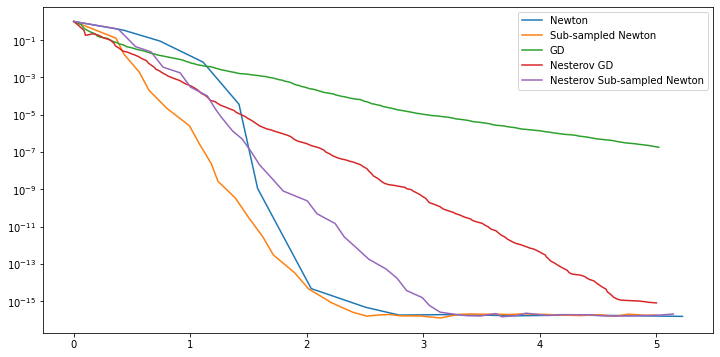

In [8]:
fig = plt.figure(figsize=(12, 6)) # set figure size
plt.yscale('log')
plt.plot(t0 , w_gaps0, label='Newton') 
plt.plot(t1 , w_gaps1, label='Sub-sampled Newton') 
plt.plot(t2 , w_gaps2, label='GD') 
plt.plot(t3, w_gaps3, label='Nesterov GD') 
plt.plot(t4, w_gaps4, label='Nesterov Sub-sampled Newton') 
plt.legend()

In [9]:
f0, f1, f2, f3 = [], [], [], []
f_stars = rl.loss(A, b, w_stars)
for k in range(ith+1):
    f0.append((rl.loss(A, b, w0[k]) - f_stars)/f_stars)
    f1.append((rl.loss(A, b, w1[k]) - f_stars)/f_stars)
for k in range(ith*8+1):
    f2.append((rl.loss(A, b, w2[k]) - f_stars)/f_stars)
    f3.append((rl.loss(A, b, w3[k]) - f_stars)/f_stars)

NameError: name 'ith' is not defined

In [ ]:
fig = plt.figure(figsize=(12, 6)) # set figure size
plt.yscale('log')
plt.plot(t0 , f0, label='Newton') 
plt.plot(t1 , f1, label='Sub-sampled Newton') 
plt.plot(t2 , f2, label='GD') 
plt.plot(t3 , f3, label='AGD') 
plt.legend()